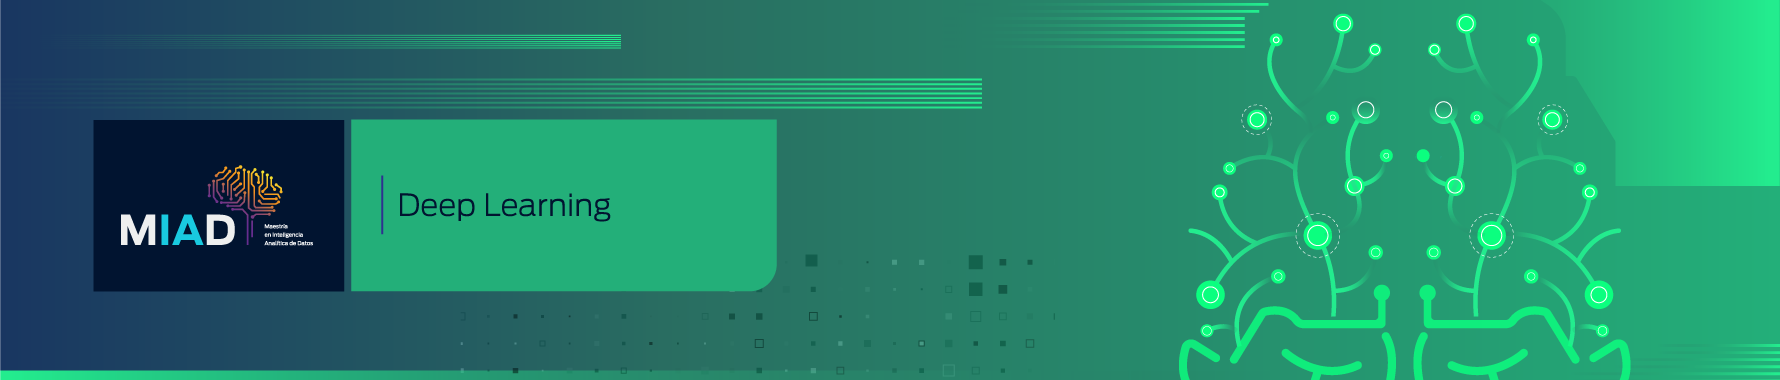

# Estrategias de implementación

## Redes neuronales usando Keras: Implementación en contexto real usando Keras

## Actividad calificada por el personal

### Propósito 

En el laboratorio "Estimación de red neuronal con múltiples capas" se propuso una implementación manual de redes neuronales usando librerías básicas de python como lo son *pandas* y *numpy*. *Google* desarrolló un *API* para el aprendizaje automático cuyo nombre es *"Keras"*, esta es escrita en *python* y es utilizada para hacer implementaciones de redes neuronales simples.

Así, en este *notebook* se pretende evaluar el uso de *keras* al aplicar una red neuronal en un contexto real. 

### Instrucciones generales

1. Para desarrollar el notebook, lo deberán descargar a un repositorio (pueden escoger el repositorio de su preferencia) para que lo puedan trabajar grupalmente.

2. Los procedimientos en el notebook deberán responderse en los espacios especificados para tal fin, debajo de cada uno de los puntos.

3. Para que la actividad sea calificada, deberán subir únicamente este mismo archivo con la extensión ".ipynb" a la actividad de "entrega calificada por el personal" correspondiente a este caso.

4. El archivo que suban debe poder ejecutarse localmente cuando sea descargado por el tutor, asumiendo que la base de datos de la actividad ya ha sido importada en el correspondiente archivo separado por comas (.csv).

### Criterios a evaluar

Los criterios que se evaluarán son:

Análisis preliminar de variables: Se presentan correlogramas, histogramas y estadísticas descriptivas de las variables de la base de datos y se hace un análisis coherente de cada uno de ellos. [30 puntos]

Estimación de un modelo utilizando redes neuronales: Se estima el modelo usando una red neuronal, se evalúa en la muestra de test y se analizan correctamente los resultados y el procedimiento realizado [30 puntos]

Elección del mejor modelo: Se elige la mejor combinación de hiperparámetros de acuerdo a los resultados obtenidos y justifica adecuadamente la selección. [40 puntos]


#### Problema

Un *manager* de un banco manifiesta preocupación porque los clientes están renunciando a las tarjetas de crédito. Este cuenta con los datos disponibles en 
https://www.kaggle.com/datasets/sakshigoyal7/credit-card-customers a cerca de 10000 clientes, si tiene productos activos o no (*"Attrition flag"*), en función de variables tales como edad, salario, estado civil, límite de tarjeta de crédito, categoría de tarjeta de crédito, etc.

Ustedes deben proponer el algoritmo para hacer la clasificación de los clientes con una red neuronal.

Tengan en cuenta que, para resolver los puntos de esta actividad, únicamente deben considerar las variables continuas (se deben eliminar las variables categóricas) y deberán eliminar las observaciones con datos faltantes.


### Librerías a importar

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import exp
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras.metrics import AUC
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier

from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn.model_selection import KFold

### 1. Análisis preliminar de variables [30 puntos]

Realicen un análisis preliminar de los predictores y de la variable de respuesta (correlogramas, histogramas y estadísticas descriptivas).

In [44]:
# Utilicen este espacio para escribir los códigos del procedimiento del punto 1 ####

df = pd.read_csv('BankChurners.csv')

df = df.drop(columns=['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
                      'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'])

df.dtypes


CLIENTNUM                     int64
Attrition_Flag               object
Customer_Age                  int64
Gender                       object
Dependent_count               int64
Education_Level              object
Marital_Status               object
Income_Category              object
Card_Category                object
Months_on_book                int64
Total_Relationship_Count      int64
Months_Inactive_12_mon        int64
Contacts_Count_12_mon         int64
Credit_Limit                float64
Total_Revolving_Bal           int64
Avg_Open_To_Buy             float64
Total_Amt_Chng_Q4_Q1        float64
Total_Trans_Amt               int64
Total_Trans_Ct                int64
Total_Ct_Chng_Q4_Q1         float64
Avg_Utilization_Ratio       float64
dtype: object

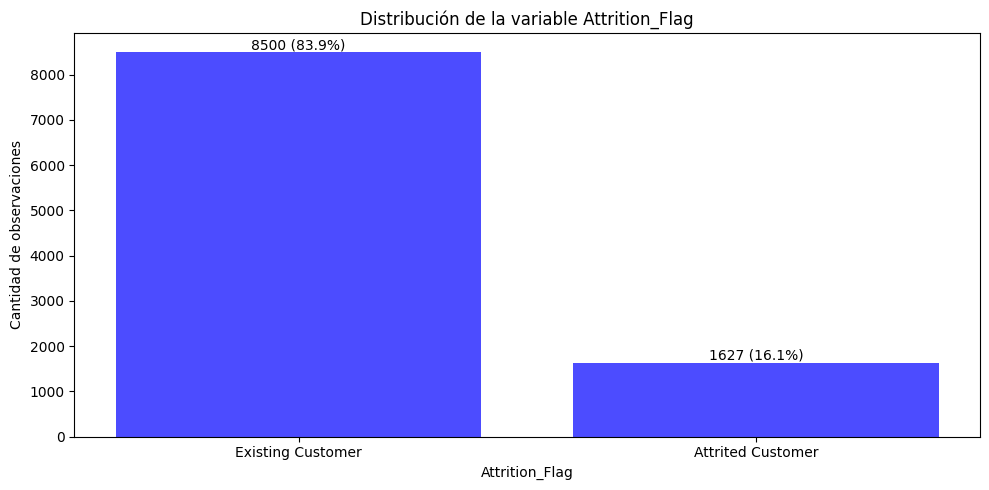

In [45]:
import matplotlib.pyplot as plt

# Contamos la frecuencia de cada clase
counts = df['Attrition_Flag'].value_counts()
labels = counts.index
total = counts.sum()


plt.figure(figsize=(10, 5))
bars = plt.bar(labels, counts.values, color='blue', alpha=0.7)


plt.title('Distribución de la variable Attrition_Flag')
plt.xlabel('Attrition_Flag')
plt.ylabel('Cantidad de observaciones')


for bar, count in zip(bars, counts.values):
    porcentaje = count / total * 100
    plt.text(bar.get_x() + bar.get_width()/2,
             bar.get_height(),
             f'{count} ({porcentaje:.1f}%)',
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


In [46]:
# Filtrar solo columnas numéricas
df_numericas = df.iloc[:,1:].select_dtypes(include=['number'])

# Contar los valores faltantes (NaN) por cada variable numérica
missing_por_variable = df_numericas.isna().sum()


print(missing_por_variable)

Customer_Age                0
Dependent_count             0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64


In [47]:
# Vemos las estadisticas descriptivas de las variables numéricas

description = df_numericas.describe()

print(description)

       Customer_Age  Dependent_count  Months_on_book  \
count  10127.000000     10127.000000    10127.000000   
mean      46.325960         2.346203       35.928409   
std        8.016814         1.298908        7.986416   
min       26.000000         0.000000       13.000000   
25%       41.000000         1.000000       31.000000   
50%       46.000000         2.000000       36.000000   
75%       52.000000         3.000000       40.000000   
max       73.000000         5.000000       56.000000   

       Total_Relationship_Count  Months_Inactive_12_mon  \
count              10127.000000            10127.000000   
mean                   3.812580                2.341167   
std                    1.554408                1.010622   
min                    1.000000                0.000000   
25%                    3.000000                2.000000   
50%                    4.000000                2.000000   
75%                    5.000000                3.000000   
max                    

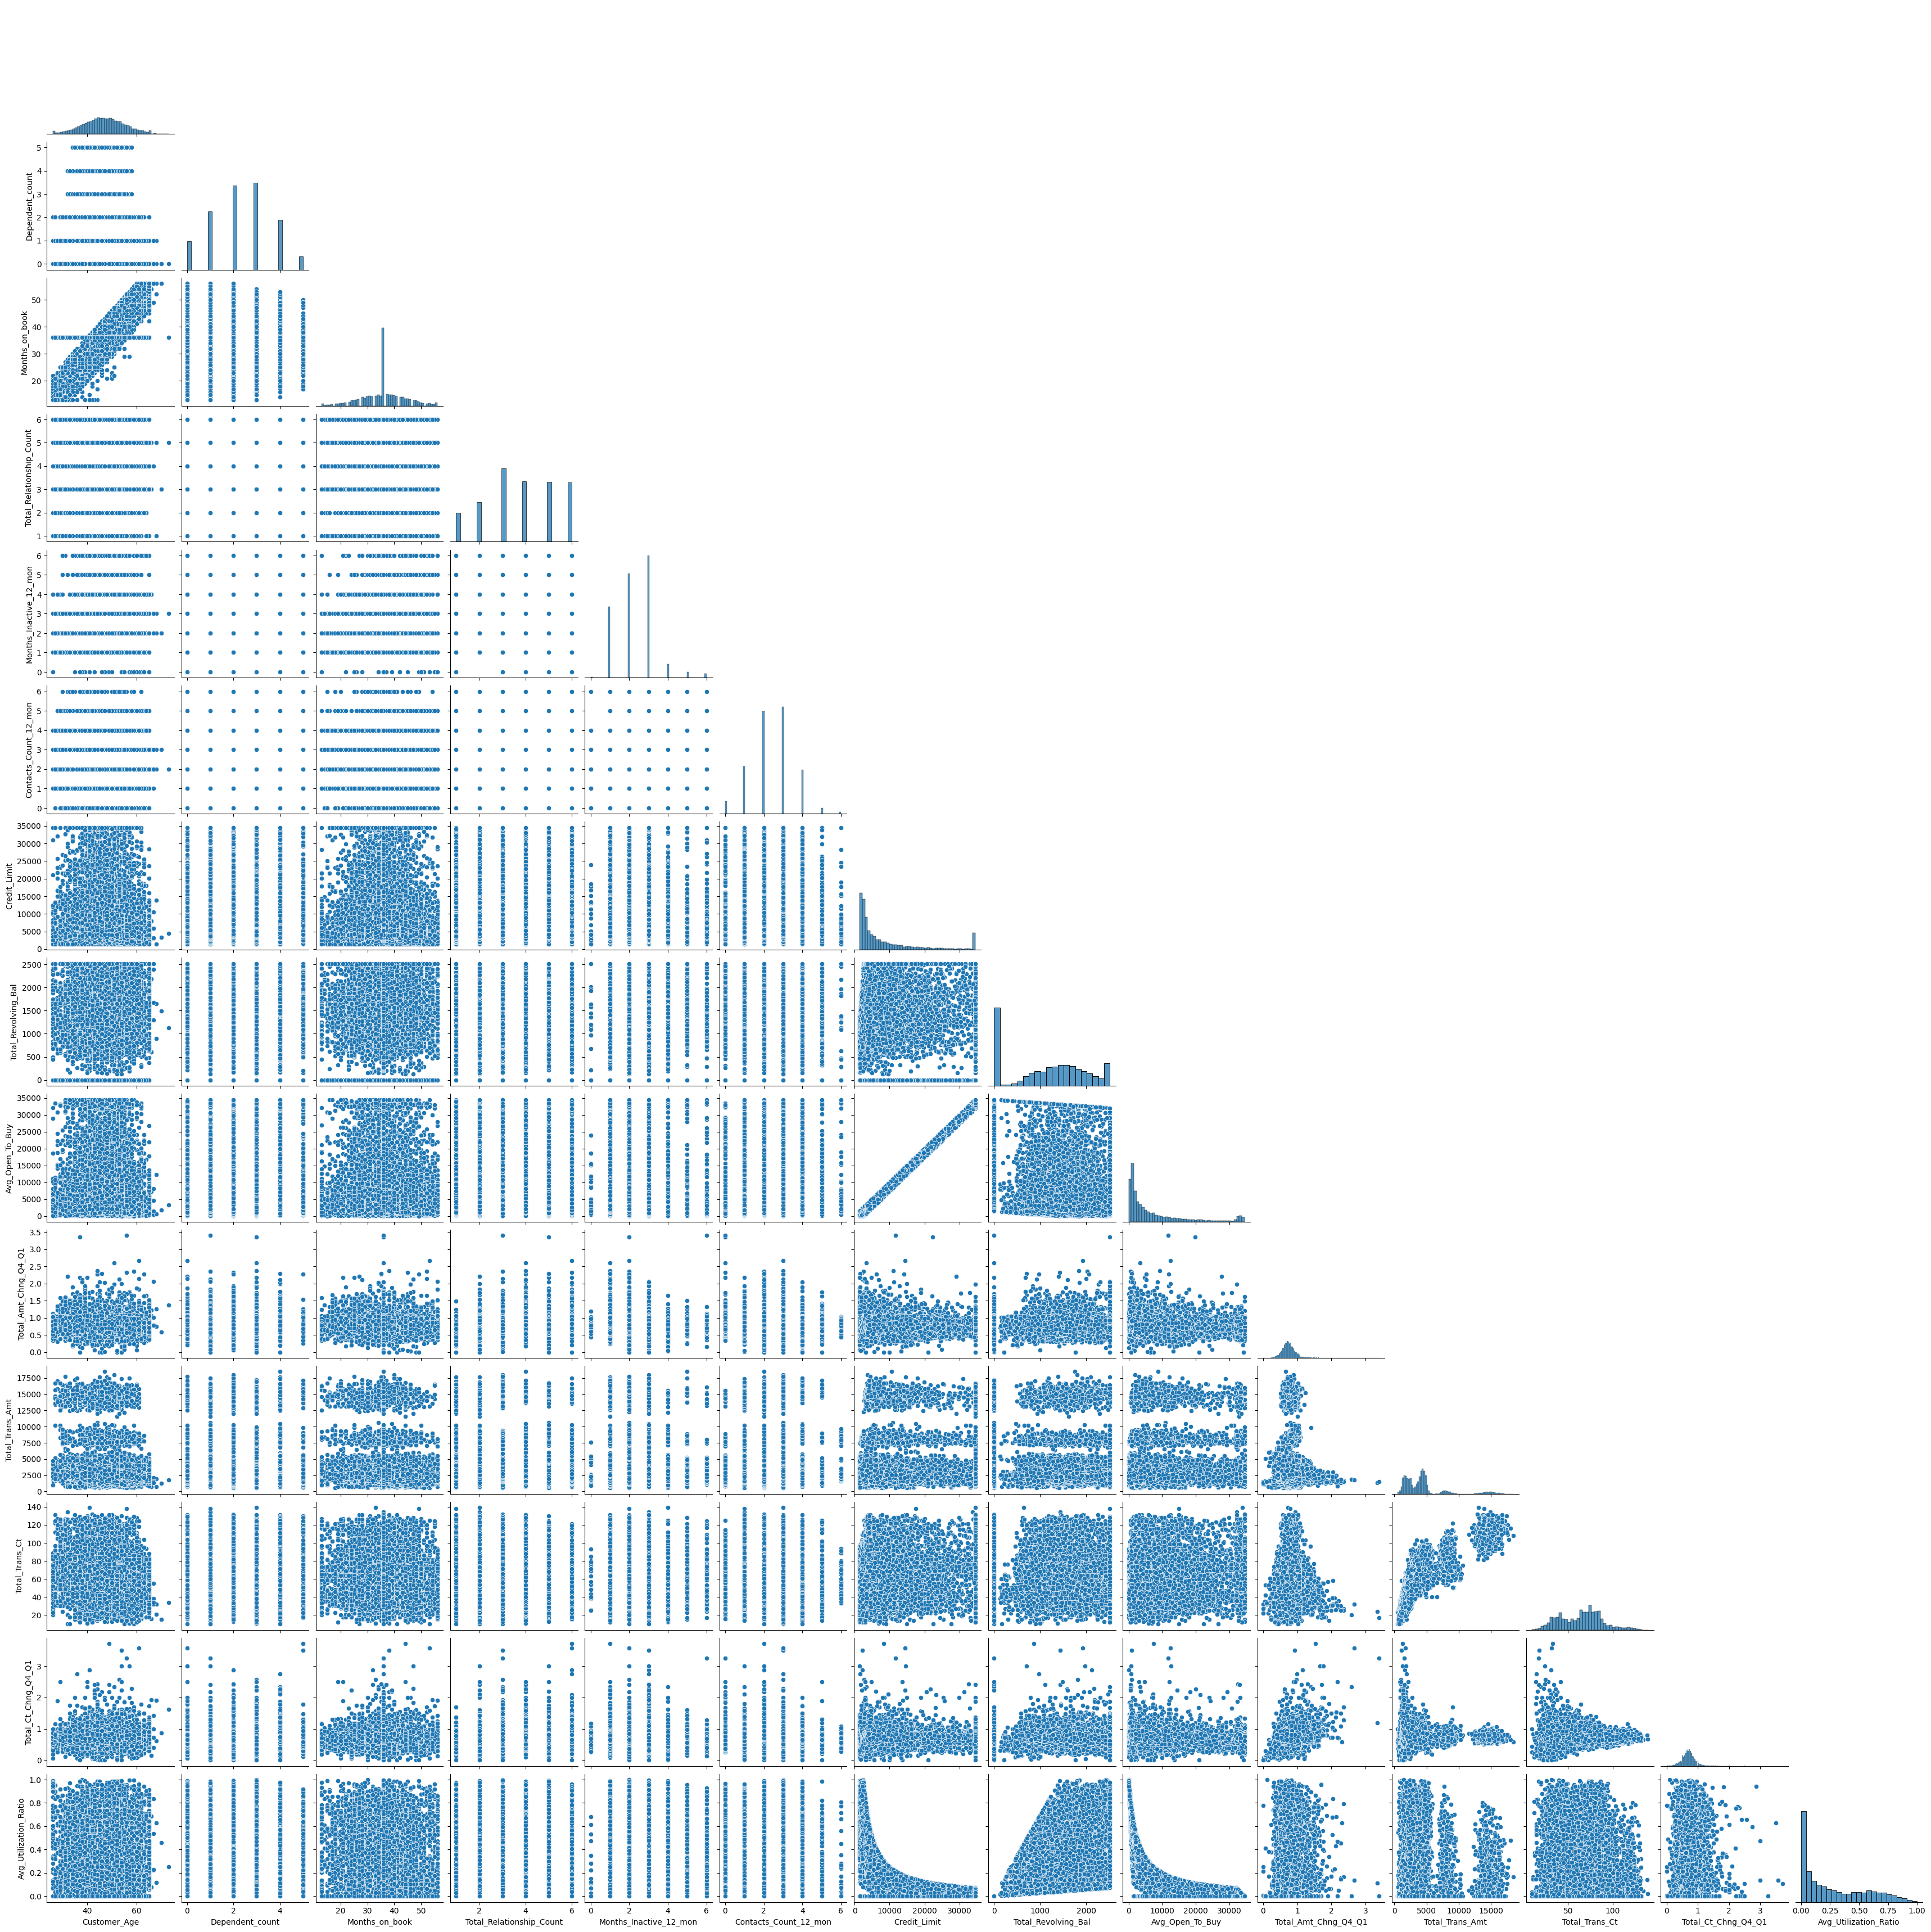

In [48]:
# Generate a pairplot for the numerical variables
sns.pairplot(df_numericas, diag_kind='hist', corner=True)

plt.show()

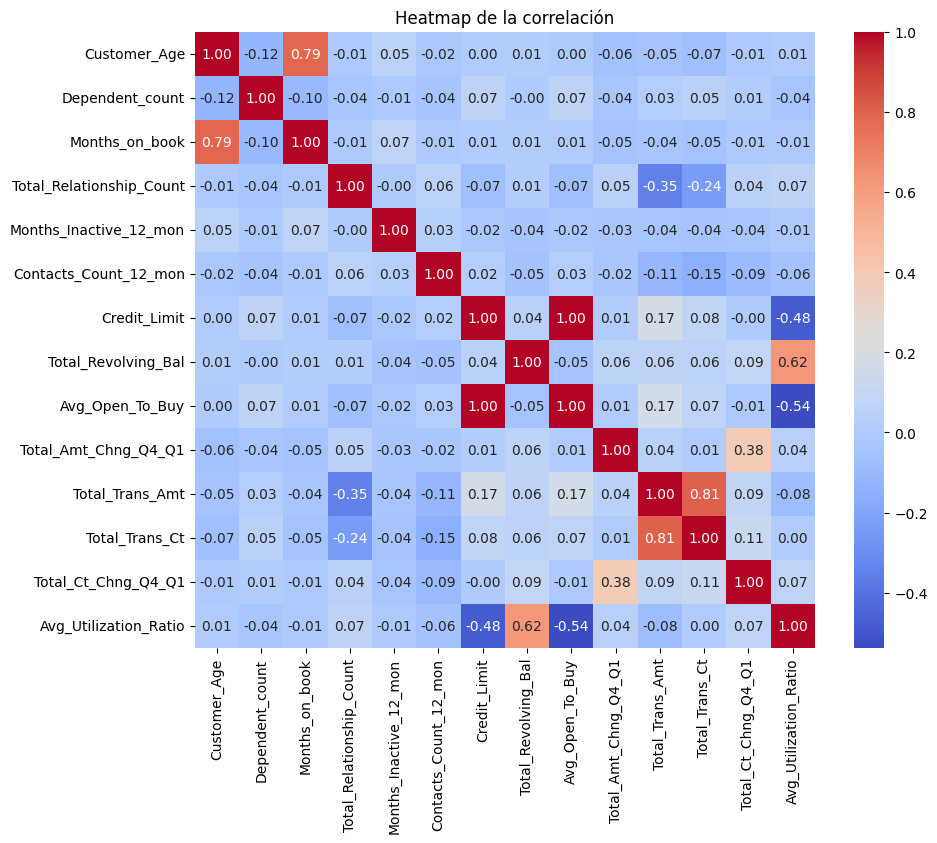

In [49]:
# Calcular la matriz de correlación
correlation_matrix = df_numericas.corr()

# Crear el heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)

# Mostrar el gráfico
plt.title("Heatmap de la correlación")
plt.show()

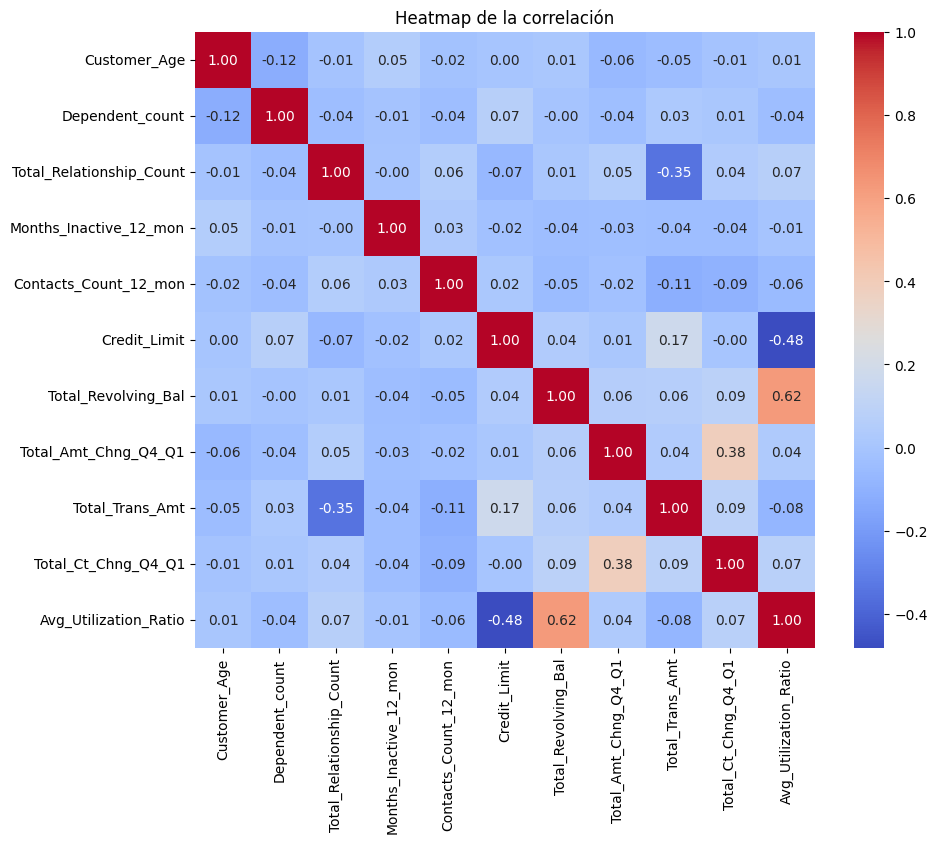

In [50]:
# Omito las variables altamente correlacionadas para evitar multicolinealidad
omit_variables = ['Months_on_book', 'Avg_Open_To_Buy', 'Total_Trans_Ct']

df_numericas = df_numericas.drop(omit_variables, axis=1)

correlation_matrix = df_numericas.corr()


plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)

# Mostrar el gráfico
plt.title("Heatmap de la correlación")
plt.show()

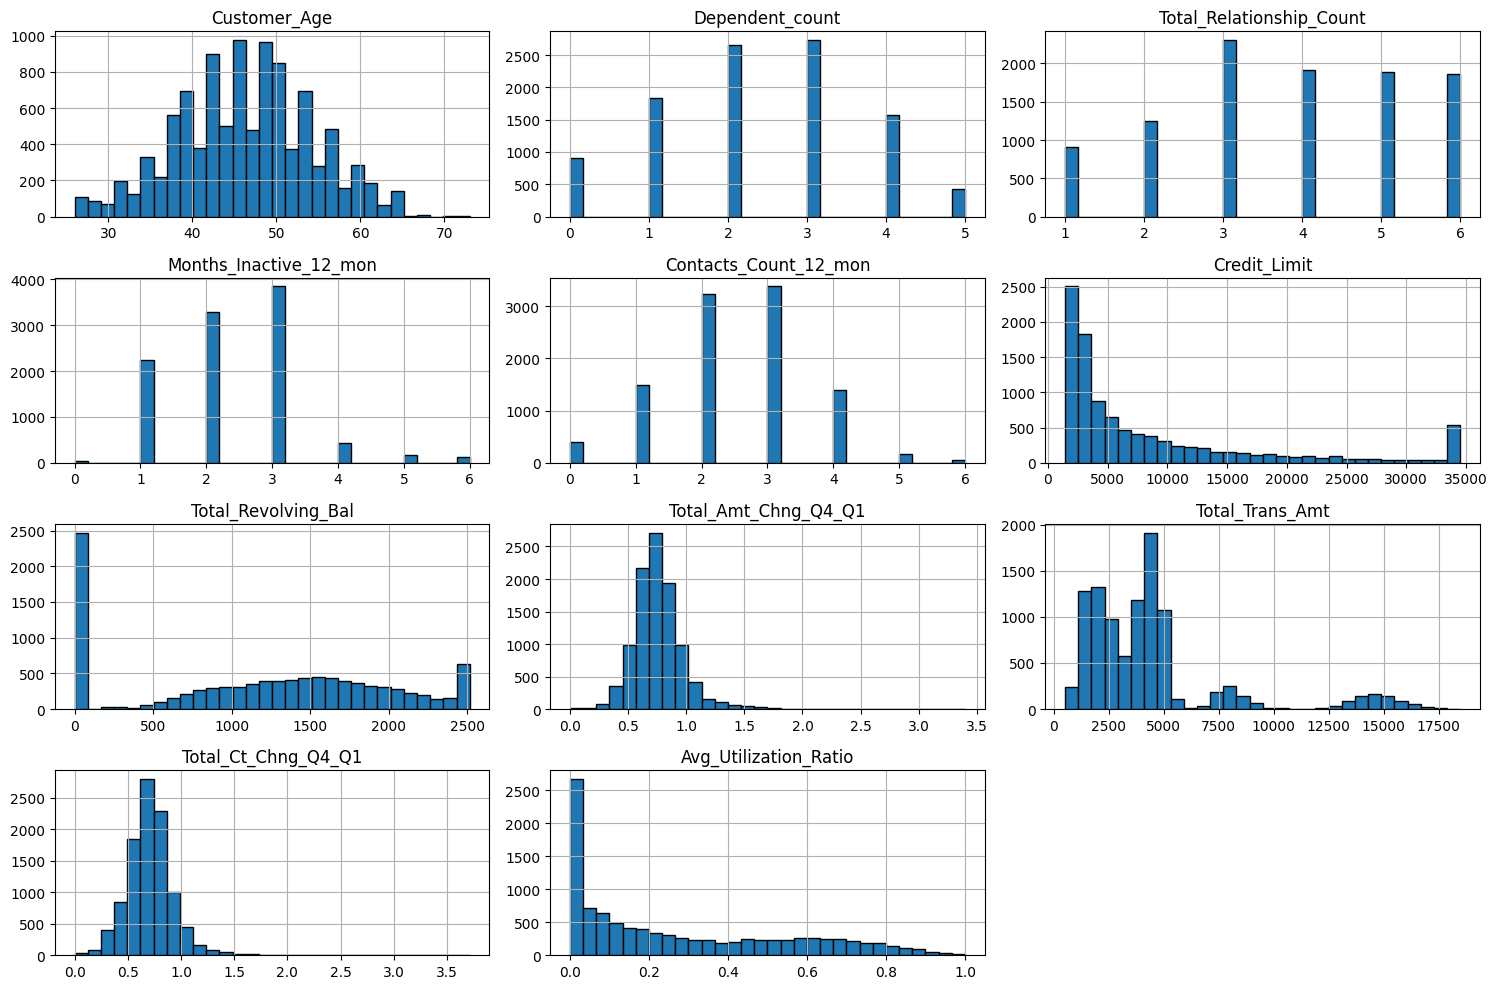

In [51]:

df_numericas.hist(bins=30, figsize=(15, 10), edgecolor='black')
plt.tight_layout()
plt.show()


(Utilicen este espacio para describir su procedimiento y escribir su análisis y conclusiones sobre el punto 1)

### 2. Estimación del modelo usando una red neuronal con keras [30 puntos]

Estimen un modelo predictivo usando la muestra de entrenamiento y evalúen su desempeño en test con hiperparámetros de su selección.

In [62]:
#### Utilicen este espacio para escribir los códigos del procedimiento del punto 2 ####

X = df_numericas
y = np.where(df['Attrition_Flag'] == 'Existing Customer', 0, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Definir el modelo
model1 = Sequential()
model1.add(Dense(16, input_dim=X_train_scaled.shape[1], activation='sigmoid'))
model1.add(Dense(8, activation='sigmoid'))
model1.add(Dense(1, activation='sigmoid'))

model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history1=model1.fit(X_train_scaled, y_train, epochs=10, batch_size=10 )

Epoch 1/10


c:\Users\USER\Documents\DL-mlp\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


811/811 ━━━━━━━━━━━━━━━━━━━━ 1s 826us/step - accuracy: 0.8366 - loss: 0.4792
Epoch 2/10
811/811 ━━━━━━━━━━━━━━━━━━━━ 1s 795us/step - accuracy: 0.8412 - loss: 0.3535
Epoch 3/10
811/811 ━━━━━━━━━━━━━━━━━━━━ 1s 787us/step - accuracy: 0.8836 - loss: 0.3188
Epoch 4/10
811/811 ━━━━━━━━━━━━━━━━━━━━ 1s 770us/step - accuracy: 0.8875 - loss: 0.3133
Epoch 5/10
811/811 ━━━━━━━━━━━━━━━━━━━━ 1s 775us/step - accuracy: 0.8855 - loss: 0.3148
Epoch 6/10
811/811 ━━━━━━━━━━━━━━━━━━━━ 1s 805us/step - accuracy: 0.8923 - loss: 0.2943
Epoch 7/10
811/811 ━━━━━━━━━━━━━━━━━━━━ 1s 775us/step - accuracy: 0.8931 - loss: 0.2958
Epoch 8/10
811/811 ━━━━━━━━━━━━━━━━━━━━ 1s 797us/step - accuracy: 0.8949 - loss: 0.2948
Epoch 9/10
811/811 ━━━━━━━━━━━━━━━━━━━━ 1s 804us/step - accuracy: 0.8914 - loss: 0.2954
Epoch 10/10
811/811 ━━━━━━━━━━━━━━━━━━━━ 1s 779us/step - accuracy: 0.8966 - loss: 0.2894


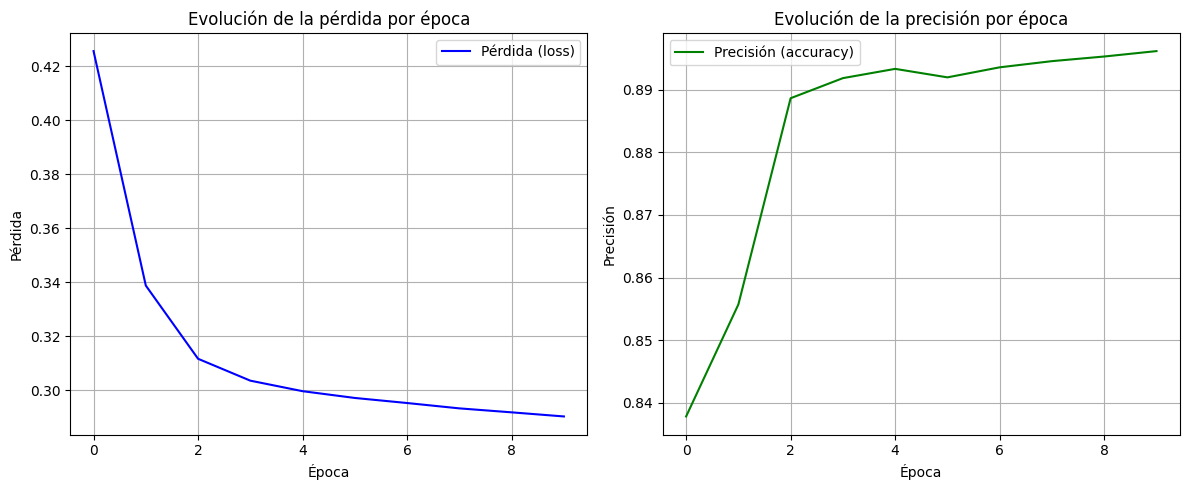

In [63]:

# Extraer historial de entrenamiento
history = history1.history

# Graficar pérdida (loss)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Pérdida (loss)', color='blue')
plt.title('Evolución de la pérdida por época')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.grid(True)
plt.legend()

# Graficar accuracy
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Precisión (accuracy)', color='green')
plt.title('Evolución de la precisión por época')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - accuracy: 0.8885 - loss: 0.3112
Accuracy: 88.45
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step
AUC para el modelo 1: 0.8227


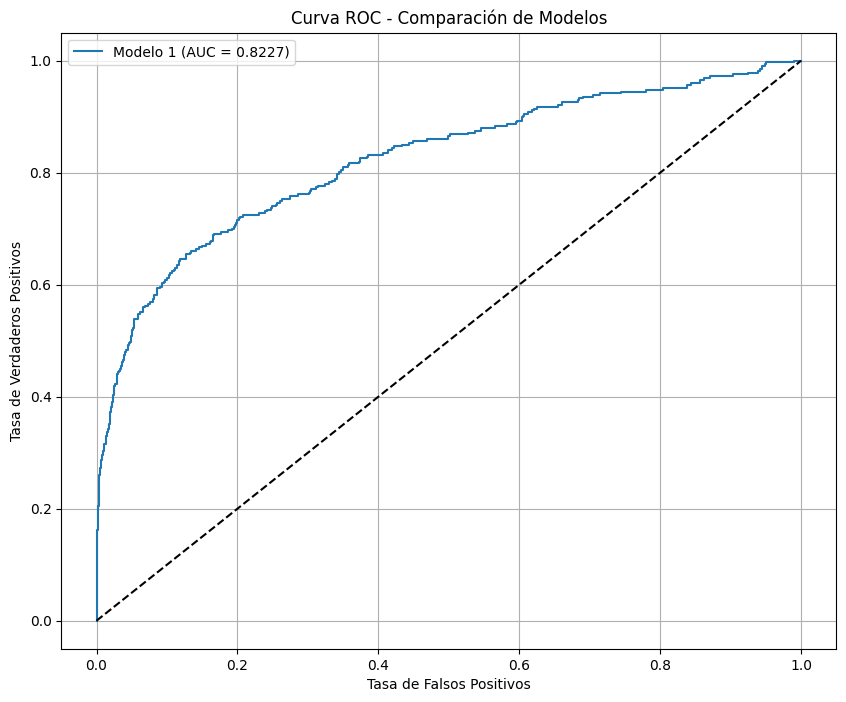

In [68]:
_, accuracy = model1.evaluate(X_test_scaled, y_test)
print('Accuracy: %.2f' % (accuracy*100))

predicciones1_prob = model1.predict(X_test_scaled) 
auc1 = roc_auc_score(y_test, predicciones1_prob)
print(f"AUC para el modelo 1: {auc1:.4f}")

plt.figure(figsize=(10, 8))

# Curva ROC para modelo 1
fpr1, tpr1, _ = roc_curve(y_test, predicciones1_prob)
plt.plot(fpr1, tpr1, label=f'Modelo 1 (AUC = {auc1:.4f})')

# Línea de referencia (modelo aleatorio)
plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - Comparación de Modelos')
plt.legend()
plt.grid(True)
plt.show()

(Utilicen este espacio para describir su procedimiento y escribir su análisis y conclusiones sobre el punto 2)

### 3. Elección del mejor modelo [40 puntos]

Ahora construyan una función que reciba por parámetro una lista de número de capas a utilizar,  números de neuronas por capa, así como funciones de activación a utilizar.

Dicha función debe entrenar el modelo con los datos de entrenamiento, evaluar con los datos de prueba para cada una de las combinaciones de hiperparámetros y encontrar cuál es la mejor combinación de hiperprámetros.  

Una vez hecho este procedimiento respondan a la siguiente pregunta:
 
¿Cómo argumenta que esta sea la selección óptima de hiperparámetros?

In [ ]:
#### Utilicen este espacio para escribir los códigos del procedimiento del punto 3 ####

def create_model(batch_size=10, epochs=10, optimizer='adam', activation='relu', neurons=[16, 16]):
    model = Sequential()
    model.add(Input(shape=(X_train_scaled.shape[1],)))
    model.add(Dense(neurons[0], activation=activation))
    for n in neurons[1:]:
        model.add(Dense(n, activation=activation))
    model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

X_train_scaled = pd.DataFrame(X_train_scaled, columns=df_numericas.columns) # Convert to DataFrame for KFold

model = KerasClassifier(build_fn=create_model, verbose=0)


param_grid = {
    'batch_size': [10, 16, 24],
    'epochs': [8, 10, 12],
    'optimizer': ['adam', 'rmsprop'],
    'activation': ['relu', 'tanh'],
    'neurons': [[16, 16],
                [16, 8],
                [8, 8, 8]]
}

all_results = []

# Manual grid search
for batch_size in param_grid['batch_size']:
    for epochs in param_grid['epochs']:
        for optimizer in param_grid['optimizer']:
            for activation in param_grid['activation']:
                for neurons in param_grid['neurons']:
                    # Create and compile model
                    model = create_model(batch_size, epochs, optimizer, activation, neurons)
                    
                    # Use cross-validation manually
                    kf = KFold(n_splits=3, shuffle=True, random_state=42)
                    cv_scores = []
                    
                    for train_idx, val_idx in kf.split(X_train_scaled):
                        # Use .iloc for pandas DataFrames
                        X_cv_train, X_cv_val = X_train_scaled.iloc[train_idx], X_train_scaled.iloc[val_idx]
                        
                        # Check if y_train is also a DataFrame/Series
                        if isinstance(y_train, (pd.DataFrame, pd.Series)):
                            y_cv_train, y_cv_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
                        else:
                            y_cv_train, y_cv_val = y_train[train_idx], y_train[val_idx]
                        
                        # Train model
                        model.fit(X_cv_train, y_cv_train, epochs=epochs, batch_size=batch_size, verbose=0)
                        
                        # Calculate AUC instead of just accuracy
                        y_pred = model.predict(X_cv_val, verbose=0)
                        auc = roc_auc_score(y_cv_val, y_pred)
                        cv_scores.append(auc)
                    
                    # Average AUC across folds
                    mean_auc = np.mean(cv_scores)
                    params = {
                        'batch_size': batch_size,
                        'epochs': epochs,
                        'optimizer': optimizer,
                        'activation': activation,
                        'neurons': neurons
                    }
                    
                    # Store the mean AUC and parameters
                    all_results.append((mean_auc, params))
                    
                    print(f"Params: {params}, Mean AUC: {mean_auc:.4f}")




Params: {'batch_size': 10, 'epochs': 8, 'optimizer': 'adam', 'activation': 'relu', 'neurons': [16, 16]}, Mean AUC: 0.9247
Params: {'batch_size': 10, 'epochs': 8, 'optimizer': 'adam', 'activation': 'relu', 'neurons': [16, 8]}, Mean AUC: 0.9337
Params: {'batch_size': 10, 'epochs': 8, 'optimizer': 'adam', 'activation': 'relu', 'neurons': [8, 8, 8]}, Mean AUC: 0.9120
Params: {'batch_size': 10, 'epochs': 8, 'optimizer': 'adam', 'activation': 'tanh', 'neurons': [16, 16]}, Mean AUC: 0.9319
Params: {'batch_size': 10, 'epochs': 8, 'optimizer': 'adam', 'activation': 'tanh', 'neurons': [16, 8]}, Mean AUC: 0.9224
Params: {'batch_size': 10, 'epochs': 8, 'optimizer': 'adam', 'activation': 'tanh', 'neurons': [8, 8, 8]}, Mean AUC: 0.9134
Params: {'batch_size': 10, 'epochs': 8, 'optimizer': 'rmsprop', 'activation': 'relu', 'neurons': [16, 16]}, Mean AUC: 0.9028
Params: {'batch_size': 10, 'epochs': 8, 'optimizer': 'rmsprop', 'activation': 'relu', 'neurons': [16, 8]}, Mean AUC: 0.9124
Params: {'batch_siz

In [82]:
# Sort all results by AUC (descending)
all_results.sort(reverse=True)

all_results[0]

(np.float64(0.95255648157072),
 {'batch_size': 10,
  'epochs': 12,
  'optimizer': 'adam',
  'activation': 'tanh',
  'neurons': [16, 16]})

Epoch 1/12


c:\Users\USER\Documents\DL-mlp\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


811/811 ━━━━━━━━━━━━━━━━━━━━ 1s 867us/step - accuracy: 0.8018 - loss: 0.4463
Epoch 2/12
811/811 ━━━━━━━━━━━━━━━━━━━━ 1s 825us/step - accuracy: 0.8915 - loss: 0.2920
Epoch 3/12
811/811 ━━━━━━━━━━━━━━━━━━━━ 1s 839us/step - accuracy: 0.8970 - loss: 0.2729
Epoch 4/12
811/811 ━━━━━━━━━━━━━━━━━━━━ 1s 825us/step - accuracy: 0.9001 - loss: 0.2664
Epoch 5/12
811/811 ━━━━━━━━━━━━━━━━━━━━ 1s 843us/step - accuracy: 0.9069 - loss: 0.2513
Epoch 6/12
811/811 ━━━━━━━━━━━━━━━━━━━━ 1s 854us/step - accuracy: 0.9106 - loss: 0.2403
Epoch 7/12
811/811 ━━━━━━━━━━━━━━━━━━━━ 1s 869us/step - accuracy: 0.9198 - loss: 0.2226
Epoch 8/12
811/811 ━━━━━━━━━━━━━━━━━━━━ 1s 842us/step - accuracy: 0.9167 - loss: 0.2222
Epoch 9/12
811/811 ━━━━━━━━━━━━━━━━━━━━ 1s 861us/step - accuracy: 0.9206 - loss: 0.2140
Epoch 10/12
811/811 ━━━━━━━━━━━━━━━━━━━━ 1s 844us/step - accuracy: 0.9215 - loss: 0.2000
Epoch 11/12
811/811 ━━━━━━━━━━━━━━━━━━━━ 1s 849us/step - accuracy: 0.9278 - loss: 0.1961
Epoch 12/12
811/811 ━━━━━━━━━━━━━━━━━━━━ 

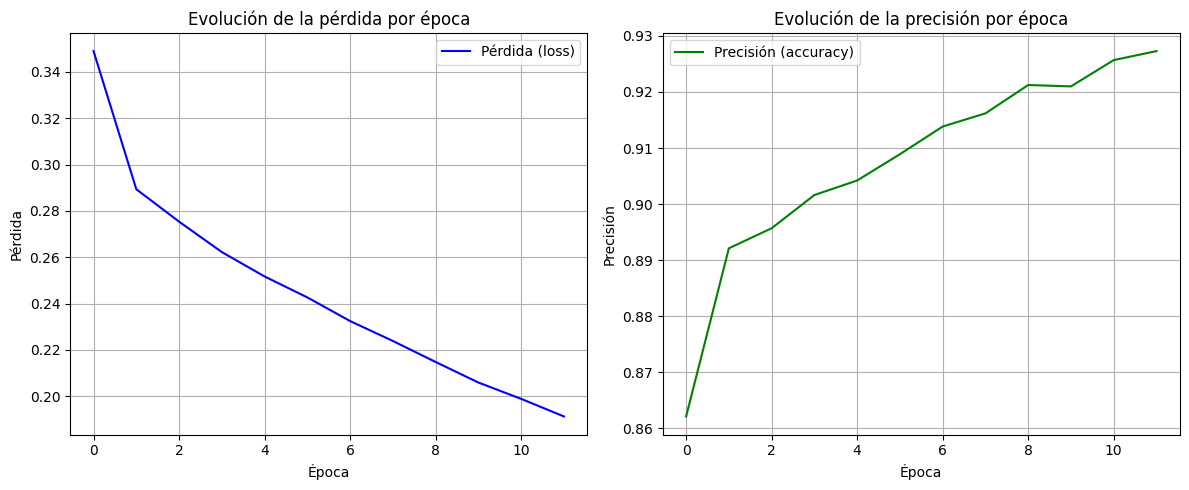

In [83]:
# Definir el modelo
modelCV = Sequential()
modelCV.add(Dense(16, input_dim=X_train_scaled.shape[1], activation='tanh'))
modelCV.add(Dense(16, activation='tanh'))
modelCV.add(Dense(1, activation='sigmoid'))

modelCV.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

historyCV=modelCV.fit(X_train_scaled, y_train, epochs=12, batch_size=10 )

# Extraer historial de entrenamiento
history = historyCV.history

# Graficar pérdida (loss)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Pérdida (loss)', color='blue')
plt.title('Evolución de la pérdida por época')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.grid(True)
plt.legend()

# Graficar accuracy
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Precisión (accuracy)', color='green')
plt.title('Evolución de la precisión por época')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - accuracy: 0.9208 - loss: 0.1989
Accuracy: 92.00
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
AUC para el modelo 1: 0.9483


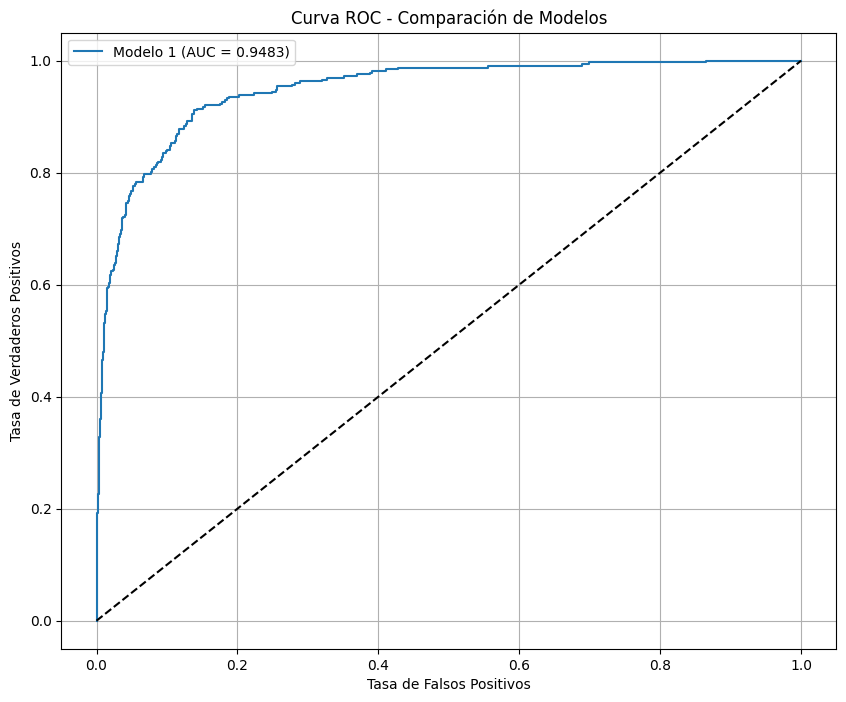

In [84]:
_, accuracy = modelCV.evaluate(X_test_scaled, y_test)
print('Accuracy: %.2f' % (accuracy*100))

predicciones_prob = modelCV.predict(X_test_scaled) 
auc1 = roc_auc_score(y_test, predicciones_prob)
print(f"AUC para el modelo 1: {auc1:.4f}")

plt.figure(figsize=(10, 8))

# Curva ROC para modelo 1
fpr1, tpr1, _ = roc_curve(y_test, predicciones_prob)
plt.plot(fpr1, tpr1, label=f'Modelo 1 (AUC = {auc1:.4f})')

# Línea de referencia (modelo aleatorio)
plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - Comparación de Modelos')
plt.legend()
plt.grid(True)
plt.show()

(Utilicen este espacio para describir su procedimiento y escribir su análisis y conclusiones sobre el punto 3)